##### Parte 2/n: Análisis Exploratior de datos y creación de un modelo de machine learning de detección de anomalías

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

In [24]:
# Importar las bibliotecas necesarias
import os  # Para operaciones con el sistema de archivos
from google.cloud import bigquery  # Para interactuar con BigQuery
import pandas as pd  # Para manejar y analizar datos en forma de DataFrames
import seaborn as sns  # Para crear gráficos estadísticos
import matplotlib.pyplot as plt  # Para visualización de datos
import numpy as np  # Para operaciones numéricas
import textwrap  # Para ajustar texto en visualizaciones
from sklearn.ensemble import IsolationForest  # Para detectar valores atípicos
from sklearn.model_selection import train_test_split  # Para dividir datos en entrenamiento y prueba
from sklearn.preprocessing import StandardScaler  # Para escalar características numéricas
from sklearn.preprocessing import LabelEncoder  # Para codificar características categóricas
import pickle  # Para guardar objetos Python
import joblib  # Para guardar modelos y preprocesadores
import plotly.express as px  # Para crear gráficos interactivos


In [2]:
# Configurar la visualización de columnas en DataFrames para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Configurar la precisión y suprimir notación científica al imprimir valores numéricos con numpy
np.set_printoptions(precision=2, suppress=True)

# Configurar el formato de visualización para valores de punto flotante en DataFrames de pandas
pd.options.display.float_format = '{:.2f}'.format


In [3]:
# Configurar la variable de entorno 'GOOGLE_APPLICATION_CREDENTIALS' para apuntar al archivo de credenciales 'key.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'key.json'

# Establecer una conexión con el servicio BigQuery utilizando el cliente de BigQuery
client = bigquery.Client()


#Importacion de datos desde Google Cloud Storage

In [4]:
# Realiza una consulta SQL para obtener los datos de la tabla específica en BigQuery
query = f"""
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2015
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2016
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2017
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2018
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2019
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2020
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2021
UNION ALL
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type,budget
FROM {os.getenv('table_id')}.OCID_2022
"""

# Ejecuta la consulta y almacena los resultados en un DataFrame de Pandas
data_raw = client.query(query).to_dataframe()
data_raw

,id,amount,method,locality,region,suppliers,buyer,year,month,internal_type,budget
0,2111072,NaN,None,FRANCISCO DE ORELLANA,ORELLANA,None,CUERPO DE BOMBEROS DEL CANTON FCO DE ORELLANA,2022,10,None,NaN
1,2108260,NaN,None,CUENCA,AZUAY,None,EMPRESA PUBLICA DE MOVILIDAD TRANSITO Y TRANSP...,2022,10,None,NaN
2,2145986,NaN,None,ESMERALDAS,ESMERALDAS,None,SUBZONA ESMERALDAS,2022,12,None,NaN
3,2130821,NaN,None,QUITO,PICHINCHA,None,CONSEJO NACIONAL ELECTORAL,2022,11,None,NaN
4,1971401,NaN,None,SAMBORONDON,GUAYAS,None,GOBIERNO AUTONOMO DESCENTRALIZADO PARROQUIAL R...,2022,6,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
17465,973599,8793.65,selective,CUENCA,AZUAY,COMPAÑIA DE SEGURIDAD JARPISEG CIA. LTDA.,COORDINACION ZONAL 6 DEL MINISTERIO DE INDUSTR...,2017,9,Catálogo electrónico - Gran compra mejor oferta,8793.65
17466,805169,5068.44,selective,CASCALES,SUCUMBIOS,CJS SECURITY SERVICES CJS CIA. LTDA.,DIRECCION DISTRITAL 21D01 CASCALES GONZALO PIZ...,2017,2,Catálogo electrónico - Gran compra mejor oferta,5068.44
17467,805170,12163.80,selective,CASCALES,SUCUMBIOS,SERSEIVI SERVICIO DE SEGURIDAD Y VIGILANCIA CI...,DIRECCION DISTRITAL 21D01 CASCALES GONZALO PIZ...,2017,2,Catálogo electrónico - Gran compra mejor oferta,12163.80
17468,962154,444.35,selective,SIMON BOLIVAR,GUAYAS,VEINCUSTODIA CIA. LTDA.,DIRECCION DISTRITAL 09D11-ALFREDO BAQUERIZO MO...,2017,9,Catálogo electrónico - Gran compra mejor oferta,444.35


In [5]:
data_raw.isnull().sum()

id                  0
amount             88
method             78
locality          231
region            231
suppliers         572
buyer               0
year                0
month               0
internal_type      78
budget           1158
dtype: int64

In [6]:
# Crear una copia del DataFrame original 'data_raw' para trabajar con él sin modificar el original
df = data_raw.copy()

# Eliminar las filas con valores faltantes (NaN) del DataFrame 'df' de manera inplace (modifica el DataFrame original)
df.dropna(inplace=True)

# Imprimir la forma (número de filas y columnas) del DataFrame 'df' después de eliminar filas con valores faltantes
print(df.shape)

# Calcular y mostrar la cantidad de valores faltantes por columna en el DataFrame 'df'
df.isnull().sum()


(15830, 11)


id               0
amount           0
method           0
locality         0
region           0
suppliers        0
buyer            0
year             0
month            0
internal_type    0
budget           0
dtype: int64

# Tablas:
- Estadisticos por internal type

In [7]:
# Obtener las categorías únicas de la columna 'internal_type' en el DataFrame 'df'
categories = df['internal_type'].unique()

# Crear una lista para almacenar los diccionarios de estadísticas
statistics_list = []

# Calcular estadísticas para cada categoría y agregarlas a la lista
for category in categories:
    # Filtrar el DataFrame 'df' para obtener solo las filas correspondientes a la categoría actual
    category_df = df[df['internal_type'] == category]

    # Calcular estadísticas básicas para la columna 'amount' dentro de la categoría actual
    statistics = {
        'Category': category,
        'Mean': category_df['amount'].mean(),    # Media
        'Median': category_df['amount'].median(),  # Mediana
        'Std Dev': category_df['amount'].std(),  # Desviación estándar
        'Min': category_df['amount'].min(),      # Valor mínimo
        'Max': category_df['amount'].max(),      # Valor máximo
    }

    # Agregar el diccionario de estadísticas a la lista
    statistics_list.append(statistics)

# Convertir la lista de diccionarios en un DataFrame de pandas
statistics_df = pd.DataFrame(statistics_list)

# Mostrar el DataFrame resultante con las estadísticas, ordenado por la columna 'Mean' en orden descendente
statistics_df.sort_values('Mean', ascending=False)



,Category,Mean,Median,Std Dev,Min,Max
18,Contrataciones con empresas públicas internaci...,11784316.36,11784316.36,NaN,11784316.36,11784316.36
9,Licitación,2075043.66,1603009.95,1808089.94,588827.14,9157797.36
19,Concurso publico,1316312.39,738230.38,1870078.24,390000.00,8379798.41
17,Comunicación Social – Proceso de Selección,756591.44,119067.44,1791560.02,7000.00,7000000.00
8,Cotización,285396.36,247470.43,196340.80,45500.00,997283.06
4,Catálogo electrónico - Gran compra puja,222839.42,60715.20,559872.32,1232.00,2352148.20
22,Concurso Público por Lista Corta Desierta,173253.58,173253.58,158750.53,61000.00,285507.15
10,Lista corta,164469.11,133648.00,103735.12,59935.20,521750.00
7,Contratos entre Entidades Públicas o sus subsi...,131219.91,17935.13,438997.28,219.77,4475834.50
13,Bienes y Servicios únicos,112748.81,20000.00,384907.89,175.44,4138325.00


# Visualizaciones

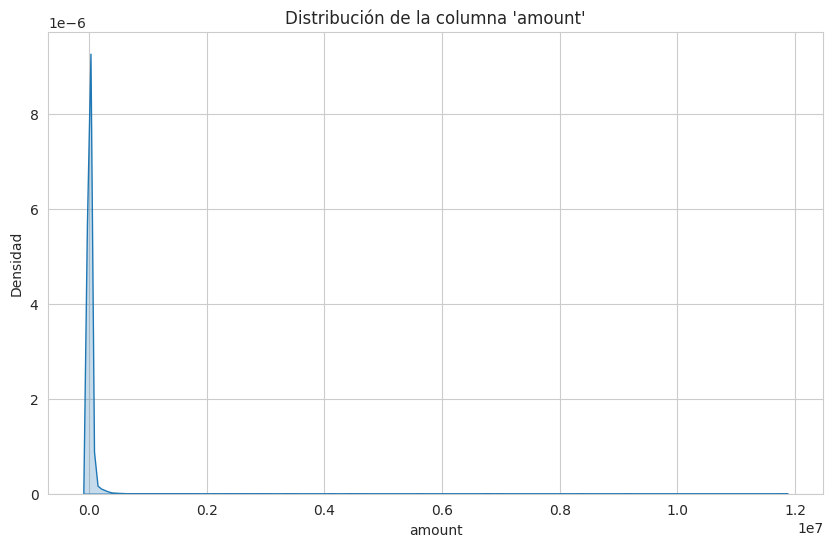

In [8]:
# Configurar el estilo de visualización de Seaborn a "whitegrid"
sns.set_style("whitegrid")

# Crear una figura de tamaño 10x6 pulgadas para la visualización
plt.figure(figsize=(10, 6))

# Generar un gráfico de densidad (KDE) de la columna 'amount' en el DataFrame 'df'
sns.kdeplot(data=df, x='amount', fill=True, common_norm=False)

# Establecer el título del gráfico
plt.title("Distribución de la columna 'amount'")

# Etiquetar el eje x
plt.xlabel("amount")

# Etiquetar el eje y
plt.ylabel("Densidad")

# Mostrar el gráfico
plt.show()



<ipython-input-9-3850010fd414>:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, ax=axes[i], fill=True)


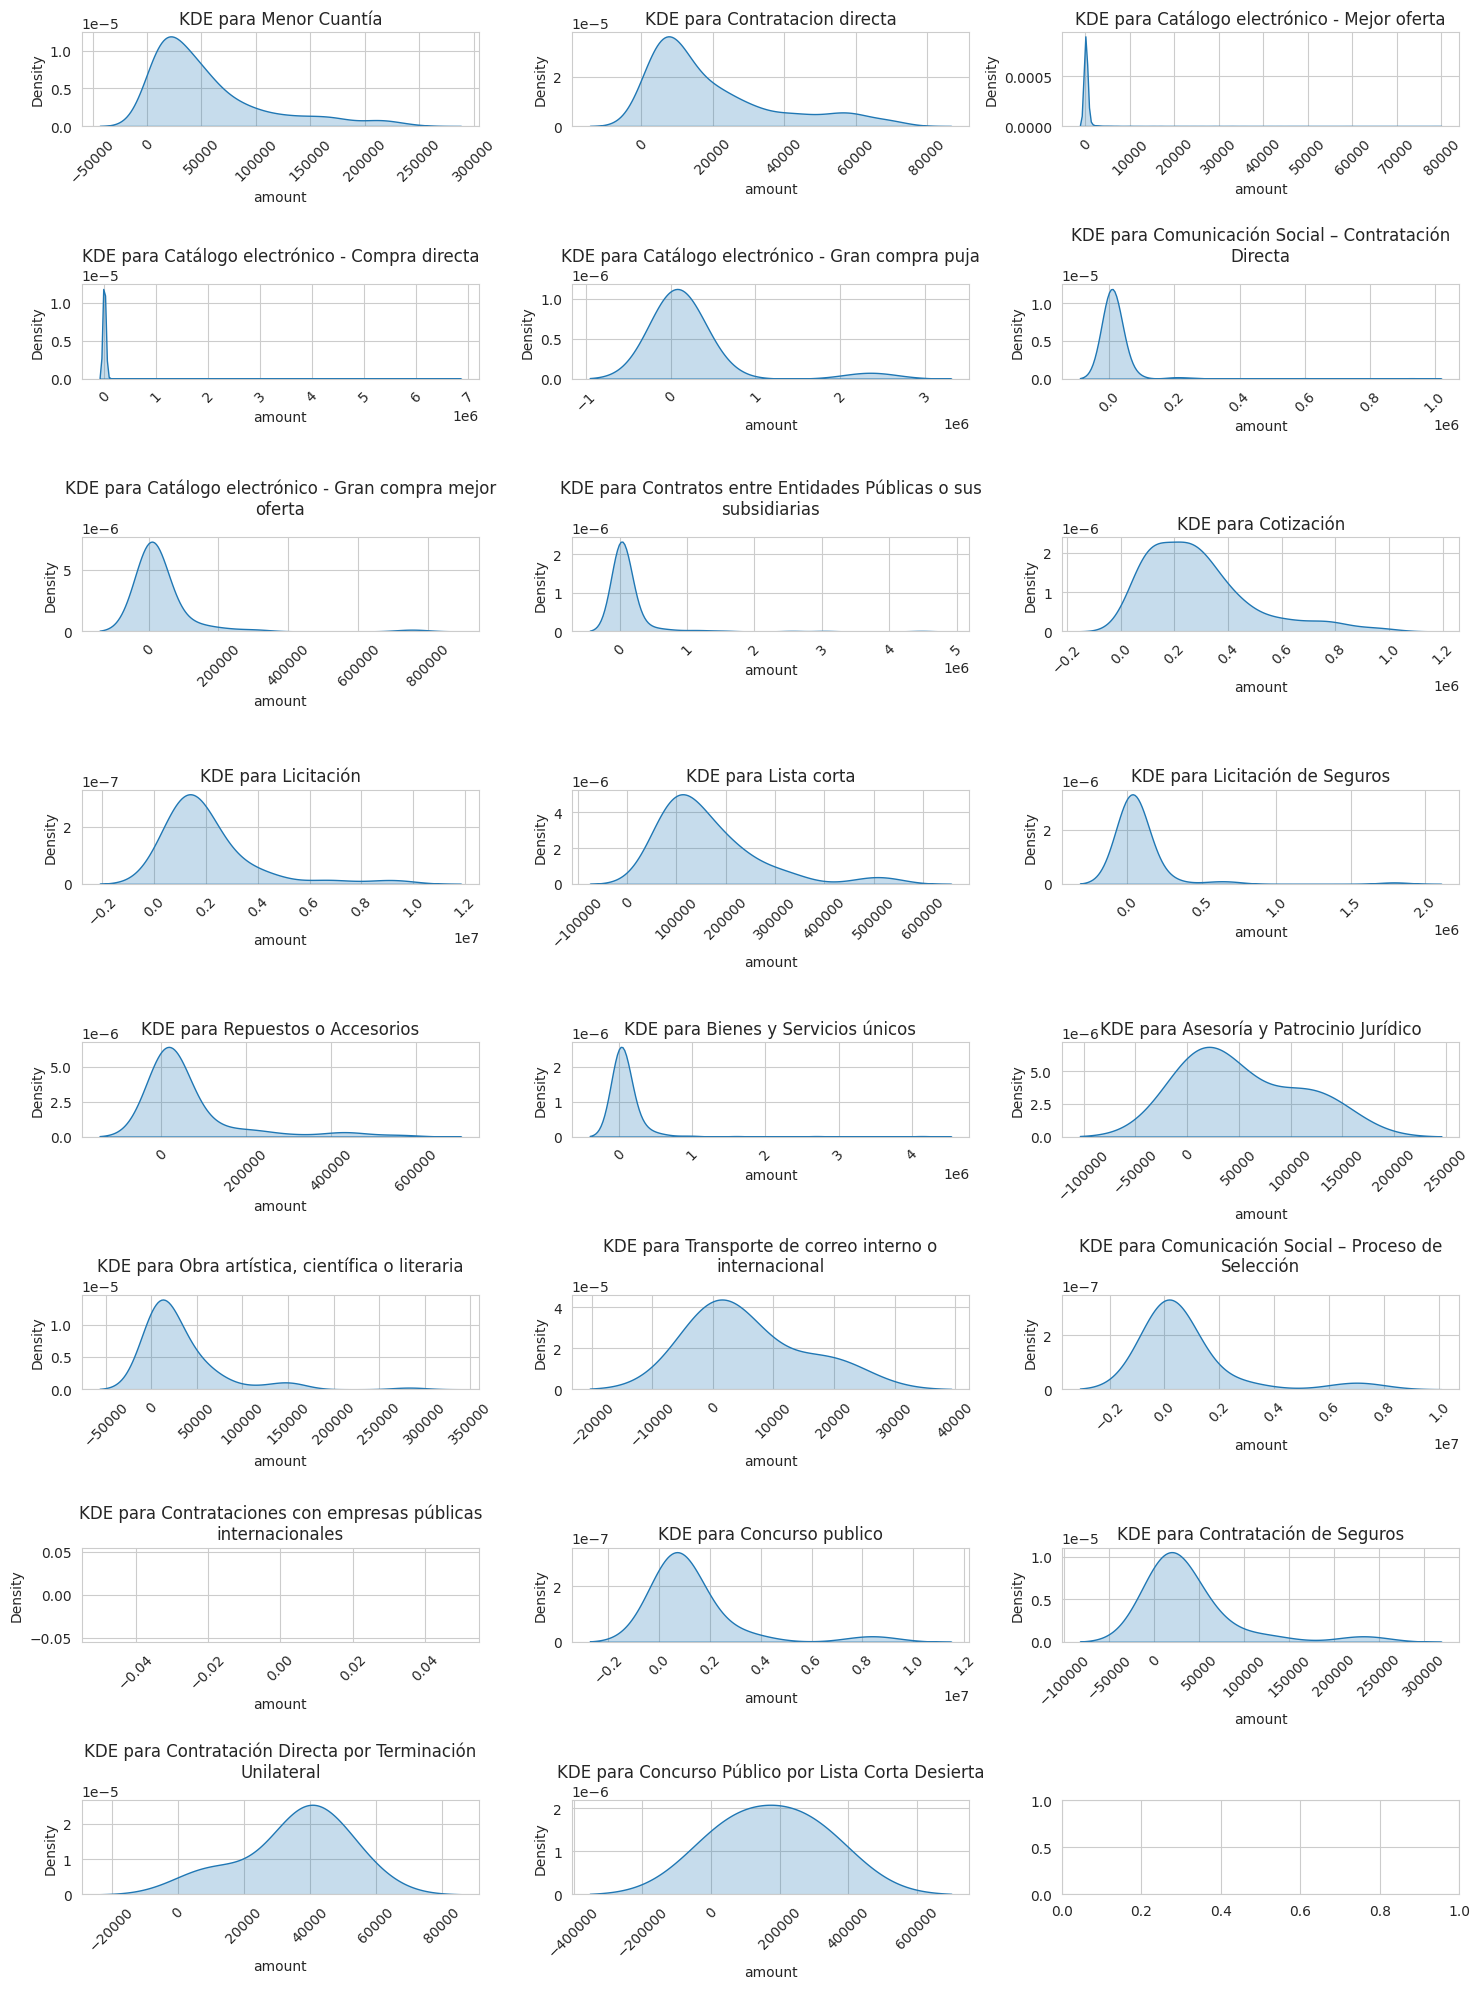

In [9]:
# Obtener las categorías únicas de la columna 'internal_type' en el DataFrame 'df'
categories = df['internal_type'].unique()

# Definir el número de filas y columnas para organizar los gráficos en subplots
n_rows = 8
n_cols = 3

# Calcular el número total de categorías y el número de figuras requeridas para mostrar todas las categorías
num_plots = len(categories)
num_figures = (num_plots + (n_rows * n_cols) - 1) // (n_rows * n_cols)

# Iterar a través de las figuras
for figure_num in range(num_figures):
    # Crear una nueva figura y un conjunto de ejes (subplots) para organizar los gráficos
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20), sharex=False)
    axes = axes.ravel()  # Aplanar el arreglo de ejes para facilitar el acceso

    # Iterar a través de los ejes para crear y mostrar los gráficos de densidad (KDE)
    for i in range(n_rows * n_cols):
        plot_idx = figure_num * (n_rows * n_cols) + i
        if plot_idx < num_plots:
            category = categories[plot_idx]
            data = df[df['internal_type'] == category]['amount']

            # Generar un gráfico de densidad (KDE) para la categoría actual y mostrarlo en el eje correspondiente
            sns.kdeplot(data, ax=axes[i], fill=True)

            # Configurar la rotación de las etiquetas del eje x
            axes[i].tick_params(axis='x', labelrotation=45)

            # Crear un título descriptivo para el gráfico
            tituloKDE = '\n'.join(textwrap.wrap(f'KDE para {category}', width=50))
            axes[i].set_title(tituloKDE)

    # Ajustar el diseño de los subplots
    plt.tight_layout()

    # Mostrar la figura actual
    plt.show()

    # Guardar la figura si hay múltiples figuras, con nombres de archivo diferentes
    if num_figures > 1:
        fig.savefig(f'kde_plots_{figure_num + 1}_of_{num_figures}.jpg', bbox_inches='tight')
    else:
        fig.savefig('kde_plots.jpg', bbox_inches='tight')

# Cerrar todas las figuras al final del proceso
plt.close('all')


<ipython-input-10-600826814d78>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.4, 0.03, 1, 0.95])


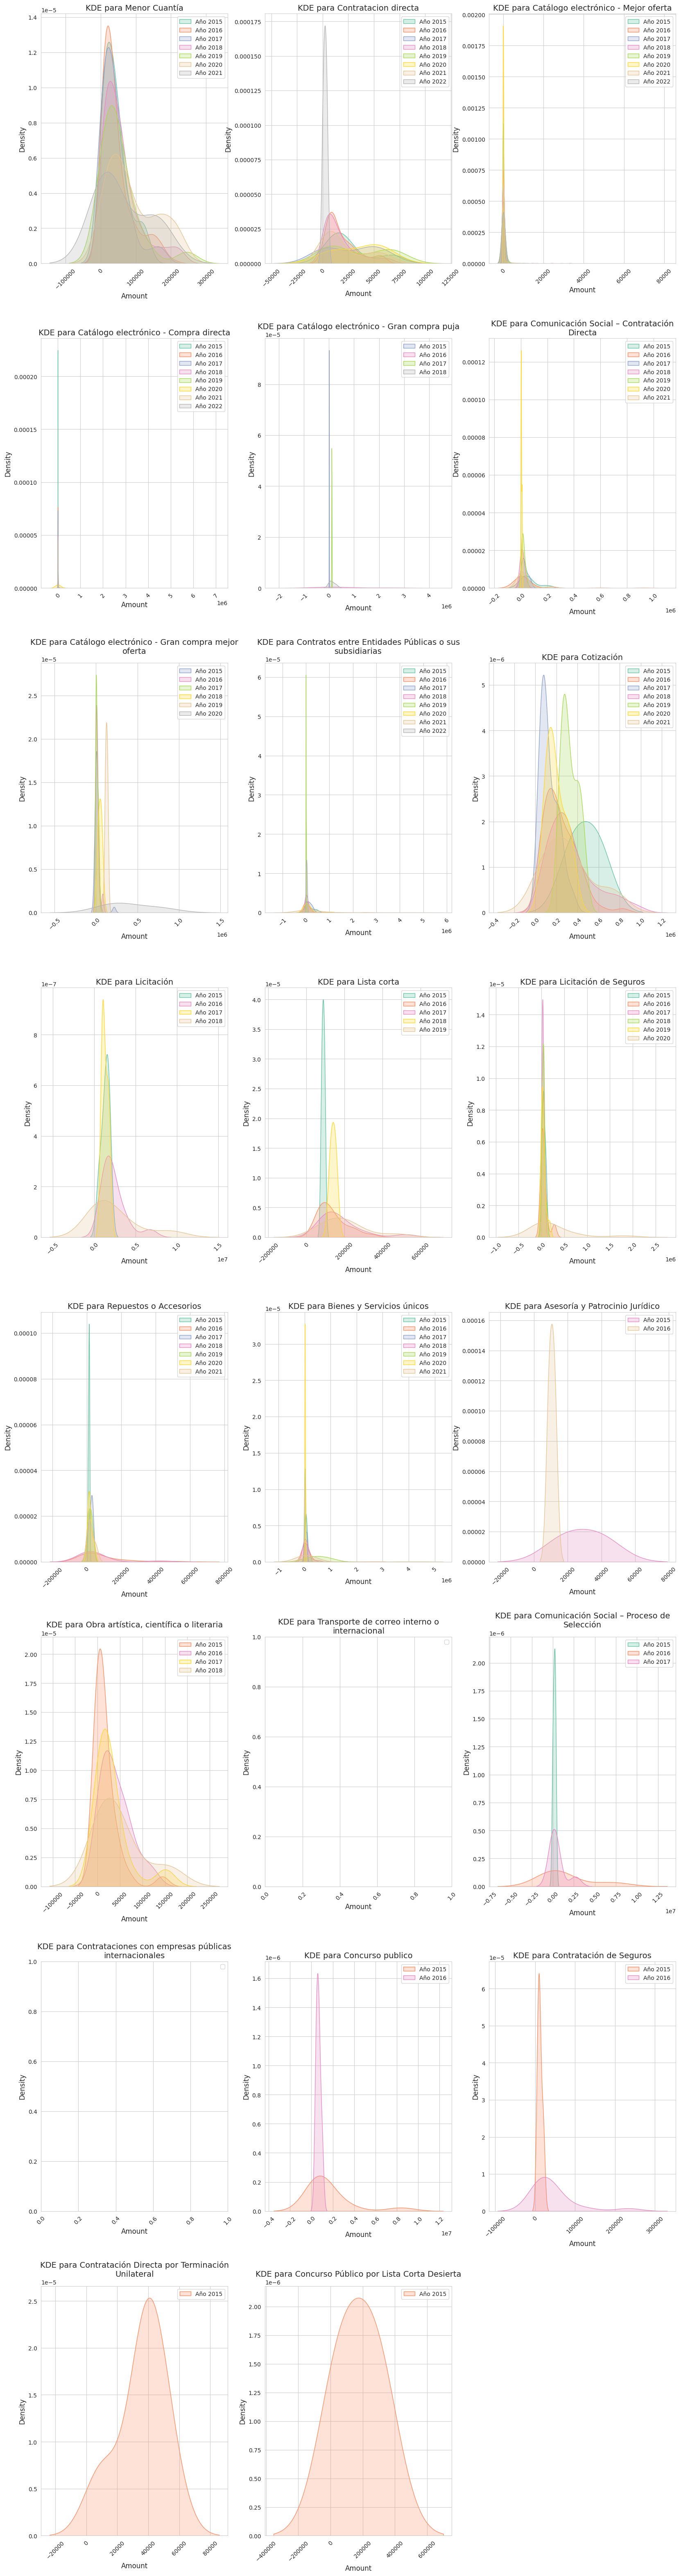

In [10]:
# Obtener las categorías únicas de la columna 'internal_type' en el DataFrame 'df'
categories = df['internal_type'].unique()

# Definir el número de filas y columnas para organizar los gráficos en subplots
n_rows = 8
n_cols = 3

# Generar una paleta de colores basada en el número de años únicos en la columna 'year'
year_colors = sns.color_palette("Set2", len(df['year'].unique()))

# Configurar el estilo de visualización de Seaborn a "whitegrid"
sns.set_style("whitegrid")

# Crear una figura y un conjunto de ejes (subplots) con un espaciado vertical definido
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 80), sharex=False, gridspec_kw={'hspace': 0.3})
axes = axes.ravel()  # Aplanar el arreglo de ejes para facilitar el acceso

# Iterar a través de las categorías
for i, category in enumerate(categories):
    # Lista para etiquetas del legend
    legend_labels = []

    # Obtener años únicos, ordenarlos y convertirlos a enteros
    years = df['year'].unique()
    years = [int(year) for year in years]
    years.sort()

    # Iterar a través de los años
    for year in years:
        # Filtrar el DataFrame para obtener datos de la categoría y año actual
        data = df[(df['internal_type'] == category) & (df['year'] == year)]['amount']

        # Generar un gráfico de densidad (KDE) para la categoría y año actual, con colores diferenciados
        sns.kdeplot(data, ax=axes[i], label=f'Año {year}', color=year_colors[year - years[0]], fill=True, warn_singular=False)

        # Agregar la etiqueta del año al legend_labels
        legend_labels.append(f'Año {year}')

    # Configurar las etiquetas y títulos de los ejes
    axes[i].tick_params(axis='x', labelrotation=45)
    tituloKDE = '\n'.join(textwrap.wrap(f'KDE para {category}', width=50))
    axes[i].set_title(tituloKDE, fontsize=14)
    axes[i].set_xlabel('Amount', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)

    # Agregar el legend al subplot
    axes[i].legend(legend_labels, loc='upper right', fontsize=10)

# Eliminar subplots no utilizados (si hay más subplots que categorías)
for i in range(len(categories), n_rows * n_cols):
    fig.delaxes(axes[i])

# Ajustar el diseño de los subplots y mostrar la figura
plt.tight_layout(rect=[0.4, 0.03, 1, 0.95])
plt.show()

# Guardar la figura como 'kde_plots_per_año.jpg' con un ajuste en los márgenes
fig.savefig('kde_plots_per_año.jpg', bbox_inches='tight')

# Cerrar la figura
plt.close(fig)


BoxPlot:

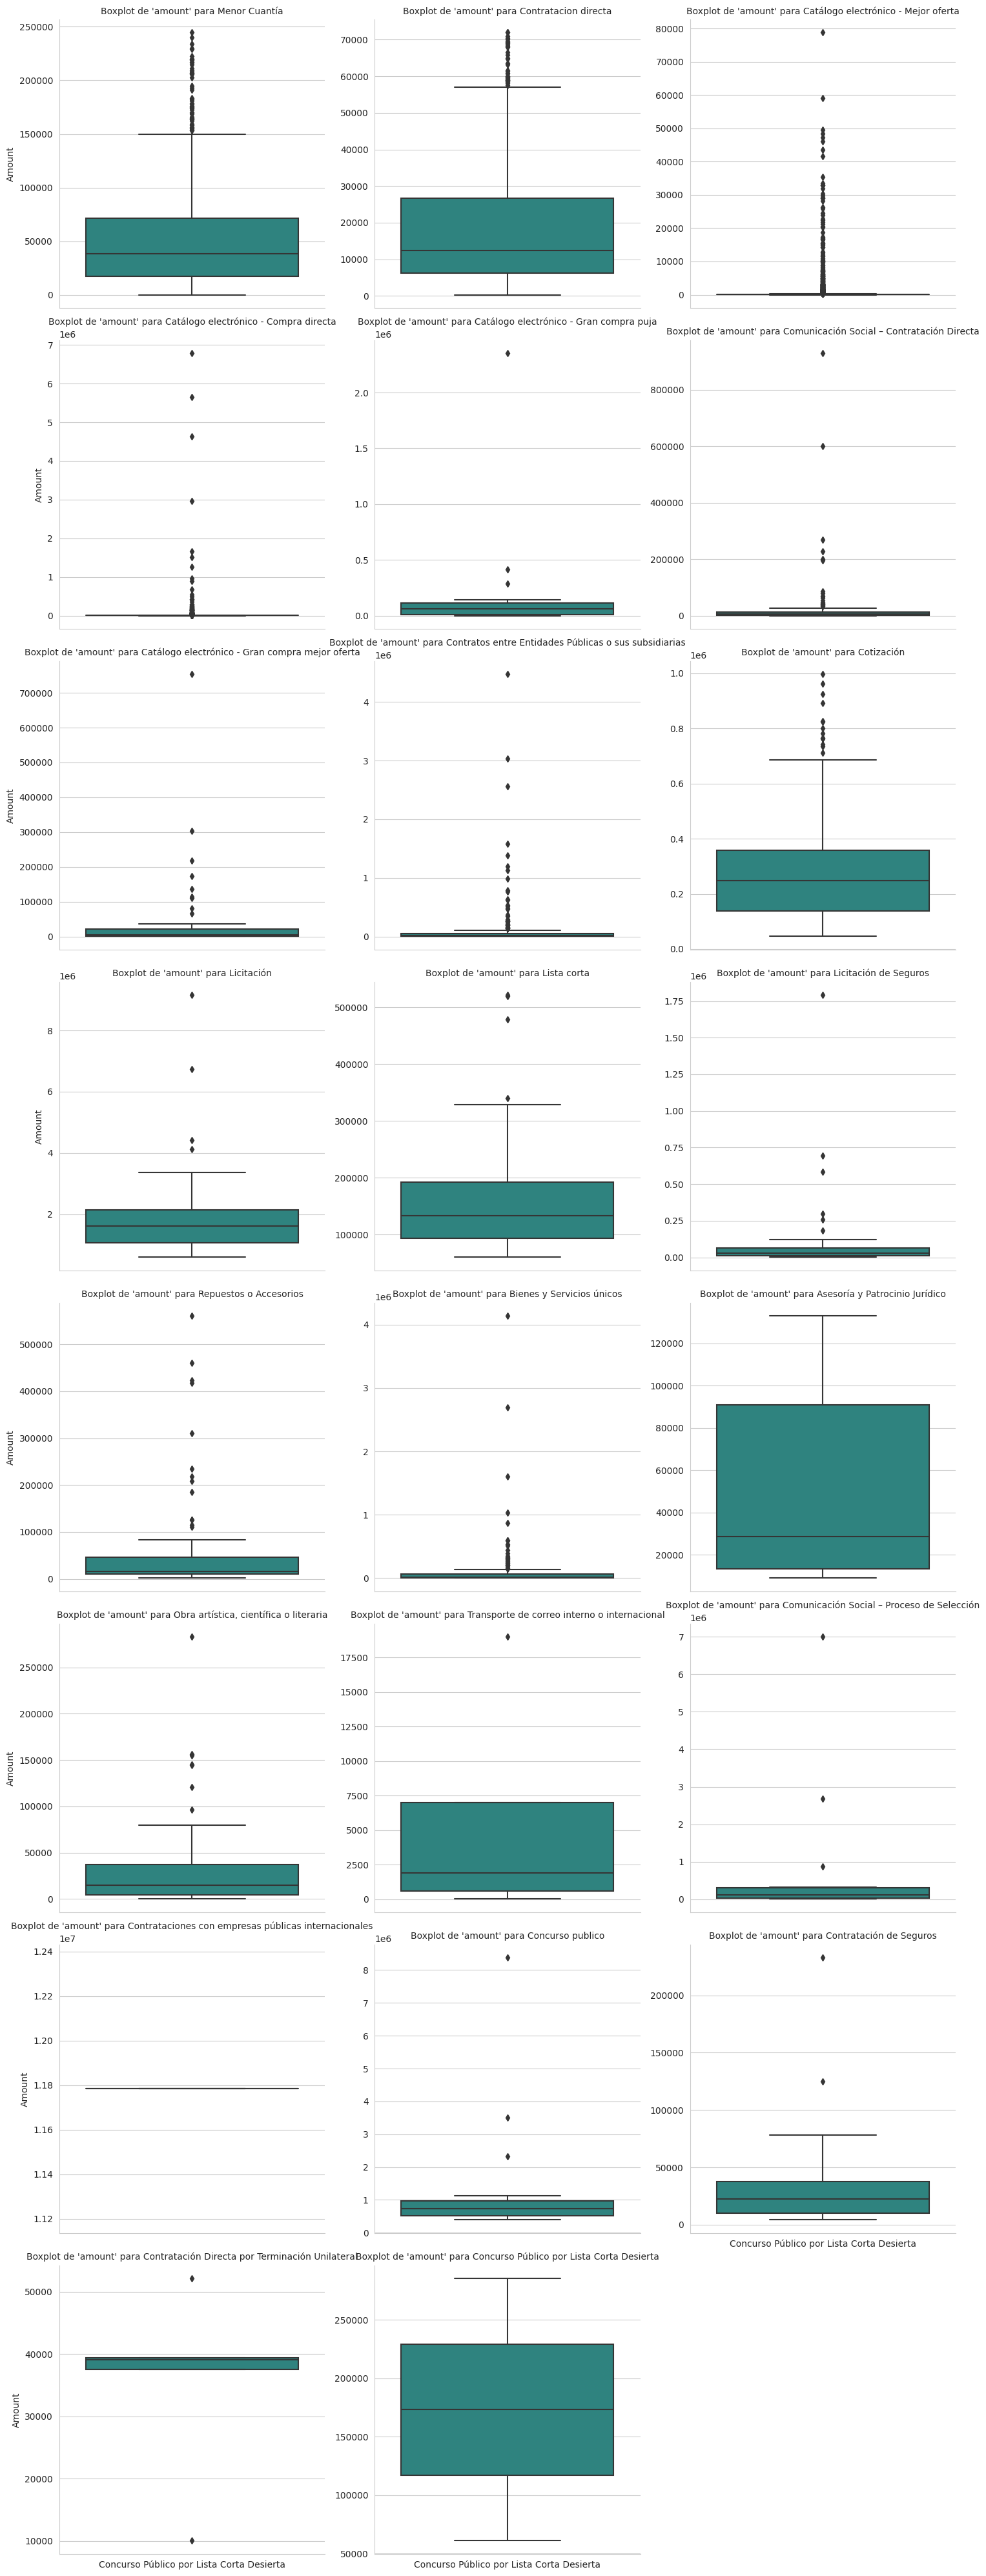

In [11]:
# Obtener las categorías únicas de la columna 'internal_type' en el DataFrame 'df'
categories = df['internal_type'].unique()

# Crear una cuadrícula de gráficos facetados (FacetGrid) utilizando Seaborn
# Se organizan en 3 columnas (col_wrap=3) para facilitar la visualización
# 'sharey=False' significa que los ejes y no comparten el mismo rango en el eje Y
# 'height=5' establece la altura de cada gráfico en la cuadrícula
g = sns.FacetGrid(df, col='internal_type', col_wrap=3, sharey=False, height=5)

# Mapear un gráfico de caja (boxplot) a cada elemento de la cuadrícula (categoría interna)
# Utilizar la paleta de colores 'viridis'
g.map_dataframe(sns.boxplot, x='internal_type', y='amount', palette='viridis')

# Configurar las etiquetas de los ejes
g.set_axis_labels("", "Amount")

# Configurar los títulos de los gráficos en la cuadrícula
# '{col_name}' se reemplazará automáticamente con el nombre de la columna interna en cada gráfico
g.set_titles("Boxplot de 'amount' para {col_name}")

# Ajustar el diseño de la cuadrícula
plt.tight_layout()

# Guardar la figura como 'Boxplots.jpg' con ajuste en los márgenes
plt.savefig('Boxplots.jpg', bbox_inches='tight')

# Mostrar la figura
plt.show()


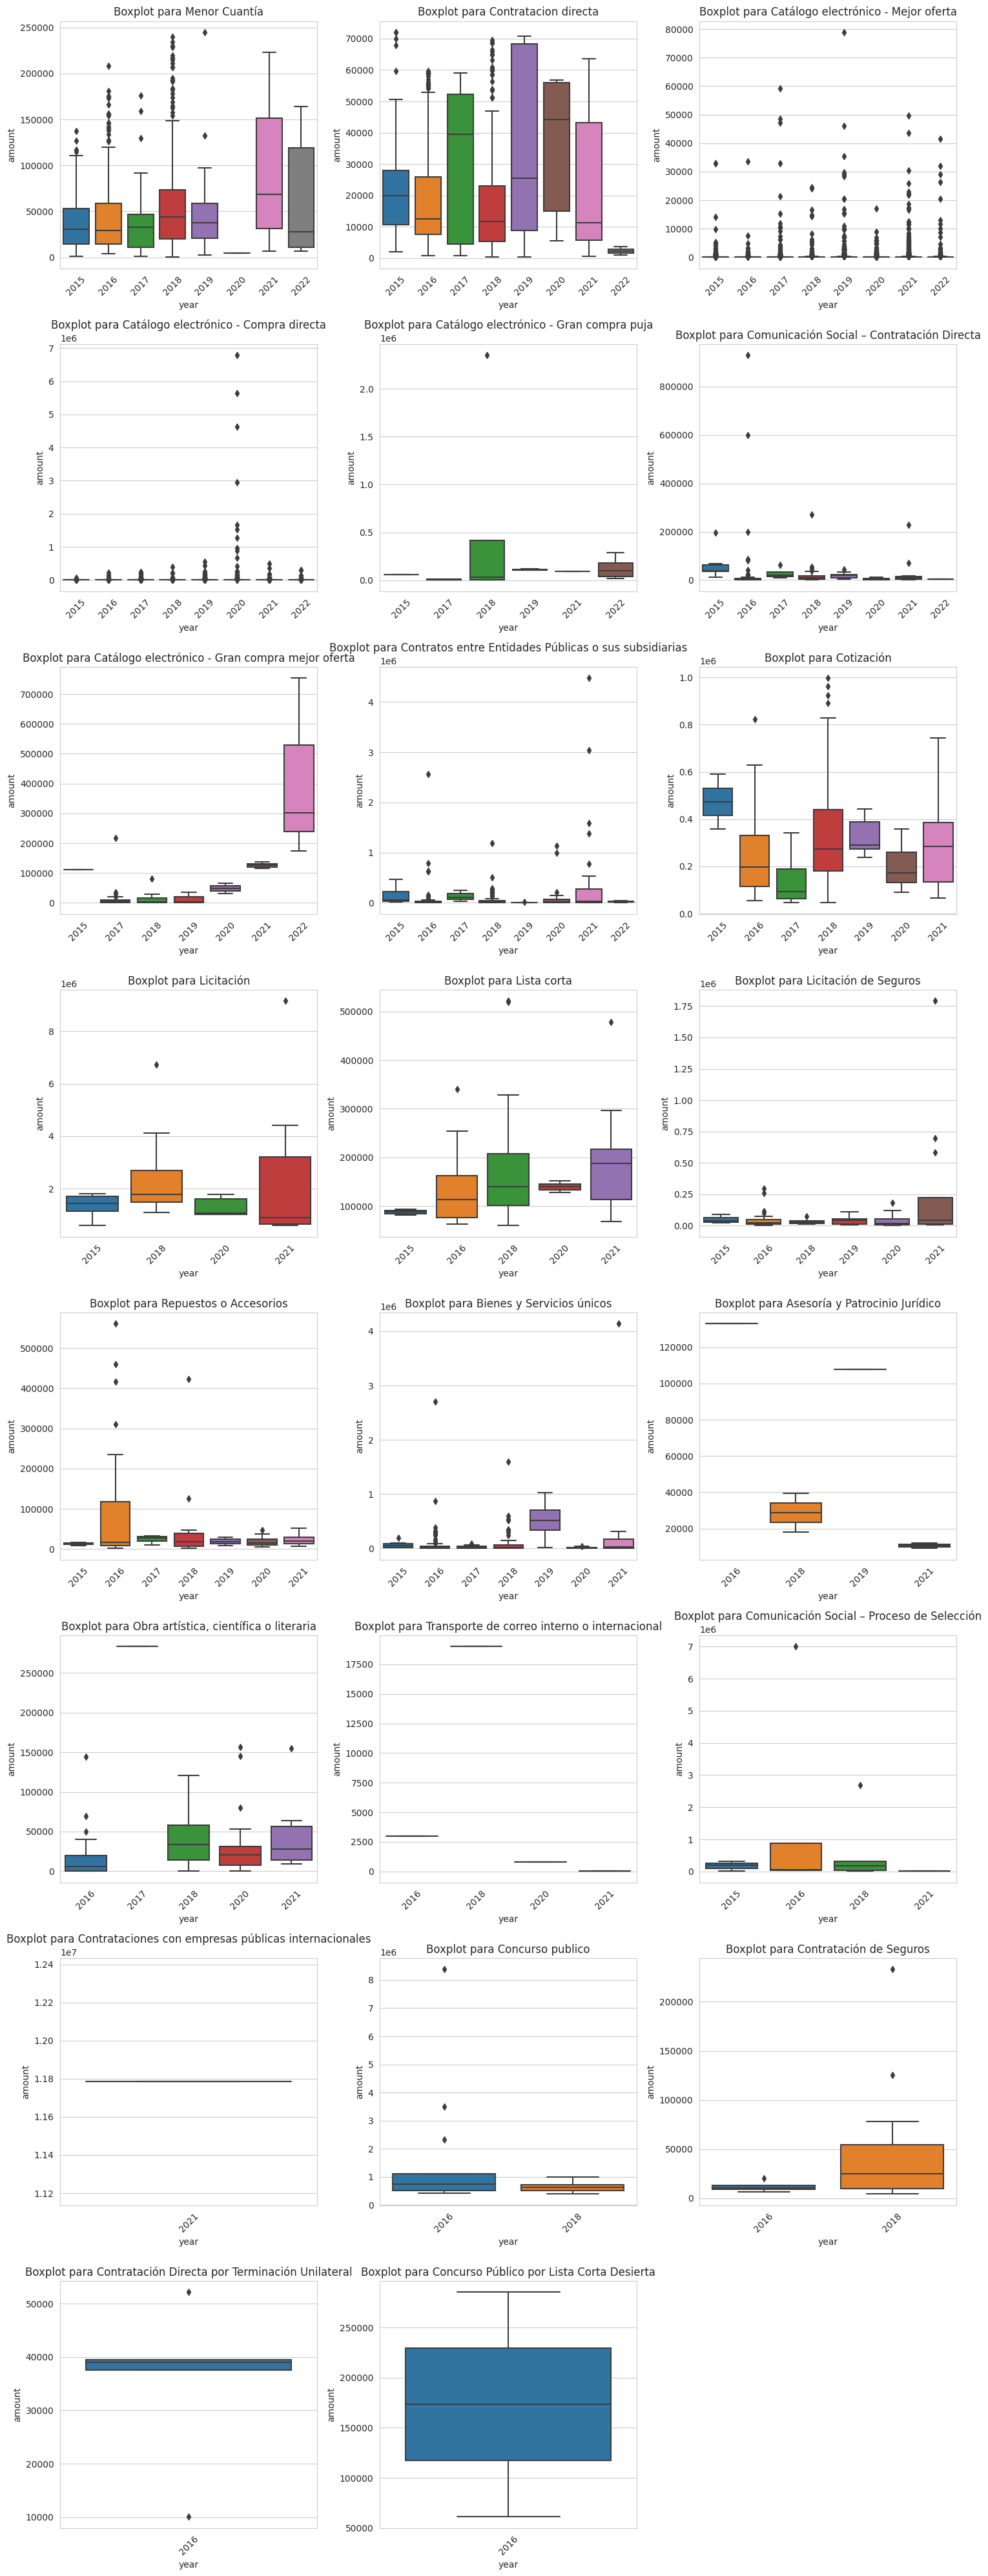

In [12]:
# Obtener las categorías únicas de la columna 'internal_type' en el DataFrame 'df'
categories = df['internal_type'].unique()

# Definir el número de filas y columnas para organizar los gráficos en subplots
n_rows = 8
n_cols = 3

# Crear una figura y un conjunto de ejes (subplots) con un tamaño de figura personalizado
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 40), sharex=False)
axes = axes.ravel()  # Aplanar el arreglo de ejes para facilitar el acceso

# Iterar a través de las categorías
for i, category in enumerate(categories):
    # Filtrar el DataFrame para obtener datos de la categoría actual
    data_category = df[df['internal_type'] == category]

    # Verificar si el DataFrame resultante no está vacío
    if not data_category.empty:
        # Generar un gráfico de caja (boxplot) para 'amount' en función de 'year' para la categoría actual
        sns.boxplot(x='year', y='amount', data=data_category, ax=axes[i])

        # Configurar la rotación de las etiquetas del eje x
        axes[i].tick_params(axis='x', labelrotation=45)

        # Establecer el título del gráfico
        axes[i].set_title(f'Boxplot para {category}')

# Eliminar subplots no utilizados (si hay más subplots que categorías)
for i in range(len(categories), n_rows * n_cols):
    fig.delaxes(axes[i])

# Ajustar el diseño de los subplots
plt.tight_layout()

# Guardar la figura como 'Boxplots_per_año.jpg' con ajuste en los márgenes
plt.savefig('Boxplots_per_año.jpg', bbox_inches='tight')

# Mostrar la figura
plt.show()


# Preprocesamiento de datos

In [ ]:
# Elimina todos los archivos con extensión .pkl en el directorio actual
!rm -rf *.pkl

# Calcula y muestra la cantidad de valores faltantes por columna en el DataFrame 'df'
df.isnull().sum()

# Crea una copia del DataFrame 'data_raw' en 'df'
df = data_raw.copy()

# Elimina las filas con valores faltantes en el DataFrame 'df' de manera inplace (modifica el DataFrame original)
df.dropna(inplace=True)

# Muestra la primera fila del DataFrame 'df' después de eliminar filas con valores faltantes
df.head(1)


In [13]:
# Crea una nueva columna 'date' en el DataFrame 'df' utilizando las columnas 'year' y 'month'
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Inicializa un escalador estándar (StandardScaler)
scaler = StandardScaler()

# Normaliza las columnas 'amount' y 'budget' y agrega las versiones normalizadas al DataFrame 'df'
df[['amount_normalized', 'budget_normalized']] = scaler.fit_transform(df[['amount', 'budget']])

# Inicializa un codificador de etiquetas (LabelEncoder) para la columna 'locality'
le_locality = LabelEncoder()

# Codifica la columna 'locality' y agrega la versión codificada al DataFrame 'df'
df['locality_ec'] = le_locality.fit_transform(df['locality'])

# Inicializa un codificador de etiquetas (LabelEncoder) para la columna 'region'
le_region = LabelEncoder()

# Codifica la columna 'region' y agrega la versión codificada al DataFrame 'df'
df['region_ec'] = le_region.fit_transform(df['region'])

# Lista de columnas seleccionadas para usar en el modelo
selected_columns = ['amount_normalized', 'budget_normalized', 'locality_ec', 'region_ec', 'date']

# Creación de un diccionario 'preprocessor' que contiene los objetos de preprocesamiento
preprocessor = {
    'scaler': scaler,
    'le_locality': le_locality,
    'le_region': le_region,
    'selected_columns': selected_columns
}

# Guardar el diccionario 'preprocessor' en un archivo 'preprocessor.pkl' usando pickle
with open('preprocessor.pkl', 'wb') as pkl_file:
    pickle.dump(preprocessor, pkl_file)

# Imprimir las columnas seleccionadas en el DataFrame 'df'
print(df[selected_columns])


       amount_normalized  budget_normalized  locality_ec  region_ec       date
123                 0.00              -0.00           74          9 2022-03-01
131                 0.03               0.03           57          7 2022-01-01
134                 0.63               0.60          156         18 2022-08-01
141                 0.56               0.53          156         18 2022-06-01
143                -0.08              -0.08          129         17 2022-02-01
...                  ...                ...          ...        ...        ...
17465              -0.07              -0.07           43          0 2017-09-01
17466              -0.08              -0.09           24         21 2017-02-01
17467              -0.05              -0.06           24         21 2017-02-01
17468              -0.11              -0.11          191          9 2017-09-01
17469              -0.10              -0.10           43          0 2017-05-01

[15830 rows x 5 columns]


In [14]:
# Imprimir la cantidad de valores faltantes por columna en el DataFrame 'df'
print(df.isnull().sum())

# Mostrar las primeras dos filas del DataFrame 'df' para inspeccionar los datos
df.head(2)


id                   0
amount               0
method               0
locality             0
region               0
suppliers            0
buyer                0
year                 0
month                0
internal_type        0
budget               0
date                 0
amount_normalized    0
budget_normalized    0
locality_ec          0
region_ec            0
dtype: int64


,id,amount,method,locality,region,suppliers,buyer,year,month,internal_type,budget,date,amount_normalized,budget_normalized,locality_ec,region_ec
123,1902478,24000.00,selective,GUAYAQUIL,GUAYAS,DISTRIBUIDORA CESAR BORJA DISTRIBORJA S.A.,DIRECCION DISTRITAL 09D08 PASCUALES 2 SALUD,2022,3,Menor Cuantía,24000.00,2022-03-01,0.00,-0.00,74,9
131,1861329,31442.85,selective,ELOY ALFARO,ESMERALDAS,GUERRERO RODRIGUEZ DIOKLER MANUEL,GOBIERNO AUTONOMO DESCENTRALIZADO DE LA PARROQ...,2022,1,Menor Cuantía,31442.85,2022-01-01,0.03,0.03,57,7


# Creacion del Modelo

In [15]:
# Obtener los valores únicos de la columna 'internal_type' en el DataFrame 'df'
valores_unicos = df['internal_type'].unique()

# Abrir un archivo llamado 'valores_unicos.txt' en modo de escritura ('w')
# y escribir cada valor único en una línea del archivo
with open('valores_unicos.txt', 'w') as archivo:
    for valor in valores_unicos:
        archivo.write(f'{valor}\n')


In [19]:
df.dtypes

id                                Int64
amount                          float64
method                           object
locality                         object
region                           object
suppliers                        object
buyer                            object
year                              Int64
month                             Int64
internal_type                    object
budget                          float64
date                     datetime64[ns]
amount_normalized               float64
budget_normalized               float64
locality_ec                       int64
region_ec                         int64
is_anomaly_prediction            object
dtype: object

In [25]:
df.isnull().sum()

id                       0
amount                   0
method                   0
locality                 0
region                   0
suppliers                0
buyer                    0
year                     0
month                    0
internal_type            0
budget                   0
date                     0
amount_normalized        0
budget_normalized        0
locality_ec              0
region_ec                0
is_anomaly_prediction    0
dtype: int64

In [ ]:
# Obtener los valores únicos de la columna 'internal_type' en el DataFrame 'df'
valores_unicos = df['internal_type'].unique()

# Definir las variables que se utilizarán para el modelo Isolation Forest
variables = ['amount_normalized', 'locality_ec', 'region_ec', 'year', 'month']

# Inicializar un modelo Isolation Forest con ciertos hiperparámetros
iforest = IsolationForest(n_estimators=100, max_samples="auto", contamination=0.01)

# Agregar una nueva columna 'is_anomaly_prediction' al DataFrame 'df' con un valor predeterminado
df['is_anomaly_prediction'] = 'VALORES Null'

# Iterar a través de los tipos de 'internal_type'
for tipo in valores_unicos:
    try:
        # Filtrar el DataFrame para obtener datos del tipo de 'internal_type' actual
        X = df[df['internal_type'] == tipo]


        # Ajustar el modelo Isolation Forest al subconjunto de datos
        iforest_fit = iforest.fit(X[variables])

        # Realizar predicciones sobre el subconjunto de datos
        predictions = iforest_fit.predict(X[variables])


        # Realizar predicciones solo para las filas que no tienen valores nulos en las variables
        X_predictions = iforest_fit.predict(X[variables])


        # Definir el nombre del archivo del modelo y guardarlo en disco usando joblib
        filename = f'./models/model_{tipo}.pkl'
        joblib.dump(iforest_fit, filename)


        # Actualizar la columna 'is_anomaly_prediction' con etiquetas 'ANOMALIA' o 'NORMAL'
        # según las predicciones del modelo (-1 para anomalía, 1 para normal)
        df.loc[X.index, 'is_anomaly_prediction'] = ['ANOMALIA' if pred == -1 else 'NORMAL' for pred in X_predictions]


    except Exception as e:
        print(f'Error al procesar {tipo}: {str(e)}')



## Visualazació de Resultados, Datos Anomalos vs Normales.

In [29]:
# Filtrar el DataFrame 'df' para obtener datos con 'internal_type' igual a 'Cotización'
X = df[df['internal_type'] == 'Cotización']

# Crear un gráfico de dispersión de tiempo con Plotly Express
# Las predicciones de anomalía se representan por colores
fig = px.scatter(
    X,
    x='date',
    y='amount',
    color='is_anomaly_prediction',  # Colorear puntos según las predicciones de anomalía
    hover_data=['suppliers', 'buyer', 'region']  # Mostrar información adicional al pasar el mouse sobre los puntos
)

# Actualizar el tamaño de los marcadores en el gráfico
fig.update_traces(marker=dict(size=8))

# Configurar el título y las etiquetas de los ejes
fig.update_layout(
    title='Gráfico de Dispersión de Tiempo',
    xaxis_title='Fecha',
    yaxis_title='Monto'
)

# Mostrar el gráfico
fig.show()


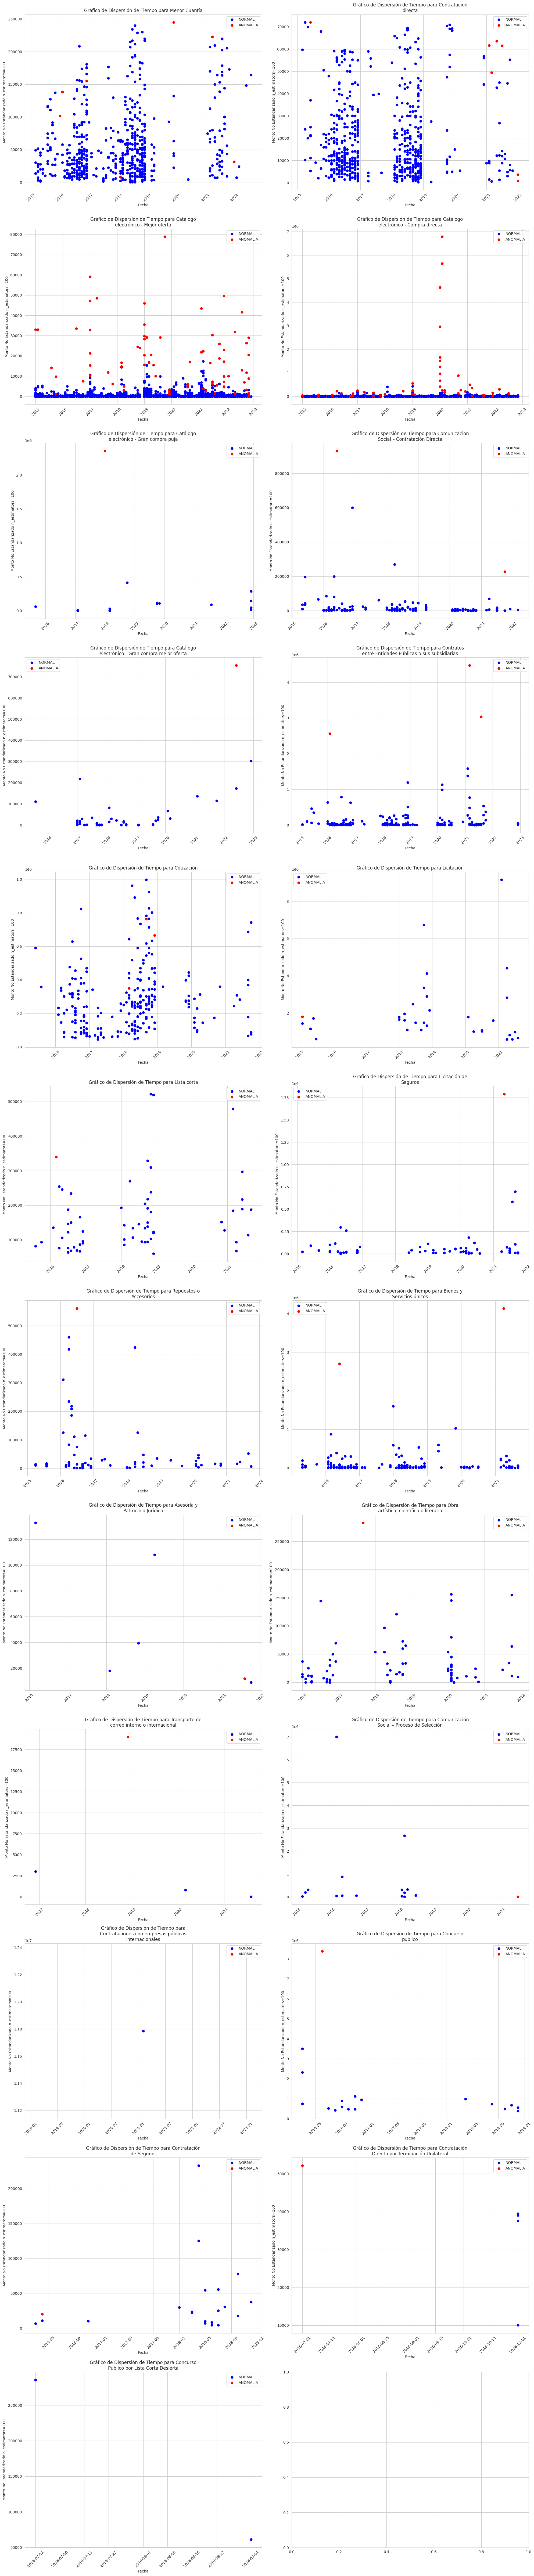

In [30]:
# Obtener los valores únicos de la columna 'internal_type' en el DataFrame 'df'
valores_unicos = df['internal_type'].unique()

# Definir el número de filas y columnas para organizar los subplots
num_filas = 12
num_columnas = 2

# Calcular el número total de subplots requeridos
num_subplots = num_filas * num_columnas

# Comprobar si el número total de subplots es menor que la cantidad de tipos únicos
# Si es así, lanzar un ValueError para ajustar el número de filas y columnas
if num_subplots < len(valores_unicos):
    raise ValueError("El número total de subplots es menor que la cantidad de tipos únicos. Ajusta el número de filas y columnas.")

# Definir el ancho y alto de cada subplot
ancho_subplot = 10
alto_subplot = 8

# Crear una figura y un conjunto de ejes (subplots) con el tamaño adecuado
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(ancho_subplot * num_columnas, alto_subplot * num_filas))

# Iterar a través de los tipos únicos y crear subplots para cada uno
for i, item in enumerate(valores_unicos):
    if i >= num_subplots:
        break

    # Filtrar el DataFrame para obtener datos del tipo 'internal_type' actual
    X = df[df['internal_type'] == item]

    # Calcular la fila y columna actual para organizar los subplots
    fila = i // num_columnas
    columna = i % num_columnas
    ax = axs[fila, columna]

    # Crear un título para el subplot
    titulo = '\n'.join(textwrap.wrap(f'Gráfico de Dispersión de Tiempo para {item}', width=50))

    # Dibujar puntos para 'NORMAL' en azul y 'ANOMALIA' en rojo
    ax.scatter(X[X['is_anomaly_prediction'] == 'NORMAL']['date'], X[X['is_anomaly_prediction'] == 'NORMAL']['amount'], label='NORMAL', color='blue')
    ax.scatter(X[X['is_anomaly_prediction'] == 'ANOMALIA']['date'], X[X['is_anomaly_prediction'] == 'ANOMALIA']['amount'], label='ANOMALIA', color='red')

    # Configurar el título y las etiquetas de los ejes
    ax.set_title(titulo)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Monto No Estandarizado n_estimators=100')
    ax.legend()
    ax.grid(True)

    # Rotar las etiquetas del eje x para una mejor legibilidad
    plt.setp(ax.get_xticklabels(), rotation=45)

# Ajustar el diseño de los subplots
plt.tight_layout()

# Guardar la figura como 'Restuls_ModelML.jpg' con ajuste en los márgenes
plt.savefig('Restuls_ModelML.jpg', bbox_inches='tight')

# Mostrar la figura
plt.show()


In [ ]:
# Mostrar los datos en 'df' que coinciden con la condición 'is_anomaly_prediction == "ANOMALIA"'
df[df['is_anomaly_prediction'] == "ANOMALIA"]

In [ ]:
import pandas_gbq

# Proyecto de Google Cloud donde se encuentra la tabla en BigQuery
project_id = os.getenv('project_id')

# ID de la tabla en BigQuery donde se cargarán los datos
table_id = f"{os.getenv('dataset_id')}.Anomalías"

# Cargar los datos del DataFrame 'df' que cumplen con la condición 'is_anomaly_prediction == "ANOMALIA"' en BigQuery
pandas_gbq.to_gbq(df[df['is_anomaly_prediction'] == "ANOMALIA"], table_id, project_id=project_id)#if_exists='replace'

# ¿Como puedos usar el modelos para hacer pronosticos?
- Funcionalidad de que estara disponible en la web.

In [31]:
# Datos del usuario o de prueba
nuevos_datos = {
    'amount': [500, 500, 2300, 4000],
    'budget': [300, 456, 22303, 234],
    'locality': ['GUAYAQUIL', 'ECHEANDIA', 'JARAMIJO', 'GUAYAQUIL'],
    'region': ['GUAYAS', 'CHIMBORAZO', 'CARCHI', 'IMBABURA'],
    'year': [2021, 2020, 2019, 2018],
    'month': [12, 11, 9, 2]
}

# Crear un DataFrame 'nuevos_df' con los datos proporcionados
nuevos_df = pd.DataFrame(nuevos_datos)

# Crear una nueva columna 'date' en 'nuevos_df' utilizando las columnas 'year' y 'month'
nuevos_df['date'] = pd.to_datetime(nuevos_df[['year', 'month']].assign(day=1))

# Utilizar el preprocesador guardado para normalizar 'amount' y 'budget'
nuevos_df[['amount_normalized', 'budget_normalized']] = preprocessor['scaler'].transform(nuevos_df[['amount', 'budget']])

# Utilizar el preprocesador guardado para codificar 'locality' y 'region'
nuevos_df['locality_ec'] = preprocessor['le_locality'].transform(nuevos_df['locality'])
nuevos_df['region_ec'] = preprocessor['le_region'].transform(nuevos_df['region'])

# Seleccionar las columnas adecuadas según el preprocesador guardado
selected_columns = preprocessor['selected_columns']

# Imprimir las columnas seleccionadas en 'nuevos_df'
print(nuevos_df[[selected_columns]])


   amount_normalized  budget_normalized  locality_ec  region_ec       date
0              -0.11              -0.11           74          9 2021-12-01
1              -0.11              -0.11           49          4 2020-11-01
2              -0.10              -0.01           81          2 2019-09-01
3              -0.09              -0.11           74         10 2018-02-01


In [32]:
nuevos_df

,amount,budget,locality,region,year,month,date,amount_normalized,budget_normalized,locality_ec,region_ec
0,500,300,GUAYAQUIL,GUAYAS,2021,12,2021-12-01,-0.11,-0.11,74,9
1,500,456,ECHEANDIA,CHIMBORAZO,2020,11,2020-11-01,-0.11,-0.11,49,4
2,2300,22303,JARAMIJO,CARCHI,2019,9,2019-09-01,-0.10,-0.01,81,2
3,4000,234,GUAYAQUIL,IMBABURA,2018,2,2018-02-01,-0.09,-0.11,74,10


In [33]:
# Lista de variables utilizadas en el modelo Isolation Forest
variables = ['amount_normalized', 'locality_ec', 'region_ec', 'year', 'month']

# Iterar a través de los tipos únicos en 'internal_type'
for tipo in valores_unicos:

    # Construir el nombre del archivo del modelo correspondiente a 'tipo'
    filename = f'./models/model_{tipo}.pkl'

    # Cargar el modelo Isolation Forest desde el archivo
    iforest_fit = joblib.load(filename)

    # Realizar predicciones de anomalía para los nuevos datos utilizando el modelo
    predictions = iforest_fit.predict(nuevos_df[variables])

    # Crear una nueva columna en 'nuevos_df' para almacenar las predicciones de anomalía
    # El nombre de la columna es {tipo}_is_anomaly_prediction
    nuevos_df[f'{tipo}_is_anomaly_prediction'] = ['ANOMALIA' if pred == -1 else 'NORMAL' for pred in predictions]


In [ ]:
nuevos_df.loc[7:]

,amount,budget,locality,region,year,month,date,amount_normalized,budget_normalized,locality_ec,region_ec,Menor Cuantía_is_anomaly_prediction,Contratacion directa_is_anomaly_prediction,Catálogo electrónico - Mejor oferta_is_anomaly_prediction,Catálogo electrónico - Compra directa_is_anomaly_prediction,Catálogo electrónico - Gran compra puja_is_anomaly_prediction,Comunicación Social – Contratación Directa_is_anomaly_prediction,Catálogo electrónico - Gran compra mejor oferta_is_anomaly_prediction,Contratos entre Entidades Públicas o sus subsidiarias_is_anomaly_prediction,Cotización_is_anomaly_prediction,Licitación_is_anomaly_prediction,Lista corta_is_anomaly_prediction,Licitación de Seguros_is_anomaly_prediction,Repuestos o Accesorios_is_anomaly_prediction,Bienes y Servicios únicos_is_anomaly_prediction,Asesoría y Patrocinio Jurídico_is_anomaly_prediction,"Obra artística, científica o literaria_is_anomaly_prediction",Transporte de correo interno o internacional_is_anomaly_prediction,Comunicación Social – Proceso de Selección_is_anomaly_prediction,Contrataciones con empresas públicas internacionales_is_anomaly_prediction,Concurso publico_is_anomaly_prediction,Contratación de Seguros_is_anomaly_prediction,Contratación Directa por Terminación Unilateral_is_anomaly_prediction,Concurso Público por Lista Corta Desierta_is_anomaly_prediction
0,500,300,GUAYAQUIL,GUAYAS,2021,12,2021-12-01,-0.11,-0.11,74,9,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOMALIA,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
1,500,456,ECHEANDIA,CHIMBORAZO,2020,11,2020-11-01,-0.11,-0.11,49,4,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
2,2300,22303,JARAMIJO,CARCHI,2019,9,2019-09-01,-0.10,-0.01,81,2,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
3,4000,234,GUAYAQUIL,IMBABURA,2018,2,2018-02-01,-0.09,-0.11,74,10,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOMALIA,NORMAL
